<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v16_implicitLearningRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v16: Implicit Learning Rate
With Adam optimizer, there's a lot of extra information that goes into the size of the update at each step. I want to directly measure the effect of that because I think sometimes it _causes_ loss oscillations.

So when we observe loss oscillations, we will be able to directly identify whether they occur because of gradients or runtime hyperparameter variability.

In [38]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout c71cf25
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at ed3a2b1 Split versions of LearningRateHistoryCallback.model_stats
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 303 bytes | 60.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   ed3a2b1..c71cf25  main       -> origin/main
Updating ed3a2b1..c71cf25
Fast-forward
 train_observability_toolkit.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [32]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm
import matplotlib.ticker as mticker

## Basics


In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

class TimingCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self._start = None
    self._begin_epoch = 0
    self._epochs = None
    self.total = None
    self.per_epoch = None

  def on_epoch_begin(self, epoch, logs=None):
    # reset after 1st epoch to discard setup noise
    if epoch <= 1:
      self._start = tf.timestamp()
      self._begin_epoch = epoch
    self._epochs = epoch+1

  def on_train_end(self, logs=None):
    now = tf.timestamp()
    self.total = (now - self._start).numpy()
    self.per_epoch = self.total / (self._epochs - self._begin_epoch)

# Basic implementation
First, we'll start with a basic data collection routine to confirm how we can most efficiently aggregate sum or mean values over the course of an epoch.

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


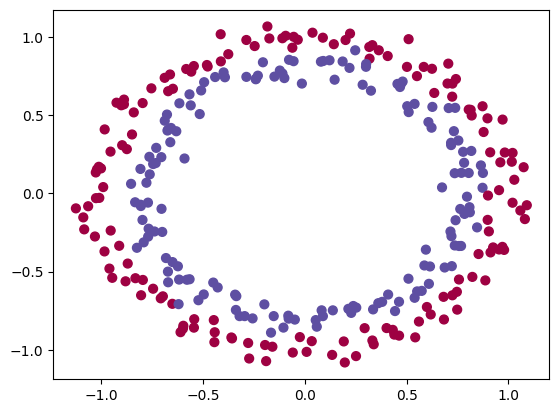

In [5]:
train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [6]:
class MyCallback1(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._variables_before = None
    self.ilr_norms = []
    self.ilr_rms = []
    self.ilr_stats = []
    self.quantiles = [0., 12.5, 25., 37.5, 50., 62.5, 75., 87.5, 100.]

  def on_train_end(self):
    self.ilr_norms = np.stack(self.ilr_norms, axis=0)
    self.ilr_rms = np.stack(self.ilr_rms, axis=0)
    self.ilr_stats = [pd.DataFrame([stat.numpy() for stat in stats], columns=self.quantiles) for stats in self.ilr_stats]

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    # free memory
    del self._variables_before

  def on_train_batch_begin(self, batch):
    self._variables_before = [tf.identity(v) for v in self.model.trainable_variables]

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    deltas = [after - before for after, before in zip(self.model.trainable_variables, self._variables_before)]
    implicit_learning_rates = [-delta/g for delta, g in zip(deltas, gradients)]
    implicit_learning_rates = [tf.gather_nd(ilr, tf.where(tf.math.is_finite(ilr))) for ilr in implicit_learning_rates]
    ilr_norms = [tf.norm(ilr) / tf.sqrt(tf.cast(tf.size(ilr), dtype=ilr.dtype)) for ilr in implicit_learning_rates]
    ilr_rms = [tf.sqrt(tf.reduce_mean(tf.square(ilr))) for ilr in implicit_learning_rates]
    ilr_percentiles = [tfp.stats.percentile(ilr, self.quantiles) for ilr in implicit_learning_rates]
    self.ilr_norms.append(ilr_norms)
    self.ilr_rms.append(ilr_rms)
    self.ilr_stats.append(ilr_percentiles)

    # if batch == 0:
    #   q = [0, 25, 50, 75, 100]
    #   print(f"Batch {batch}:")
    #   for v_idx, (delta, g, ilr, ilr_p) in enumerate(zip(deltas, gradients, implicit_learning_rates, ilr_percentiles)):
    #     print(f" [{v_idx}]: delta{delta.shape}={tfp.stats.percentile(delta, q)}, g{g.shape}={tfp.stats.percentile(g, q)}, ilr{ilr.shape}={ilr_p}")

reload(tot)
tf.config.run_functions_eagerly(False)

cb = MyCallback1()
timing = TimingCallback()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=5, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(), cb, timing])
duration = (tf.timestamp() - start).numpy()
print(f"Total training time: {duration:.2f} secs. Average: {timing.per_epoch*1000:.2f}ms/epoch")


Epoch     1 - 15.14s/epoch: accuracy: 0.5133  binary_crossentropy: 0.8359  loss: 0.8359  mse: 0.2963  
Epoch     2 - 1.86s/epoch: accuracy: 0.5500  binary_crossentropy: 0.7530  loss: 0.7530  mse: 0.2659  
Epoch     3 - 1.52s/epoch: accuracy: 0.5733  binary_crossentropy: 0.7282  loss: 0.7282  mse: 0.2603  
Epoch     4 - 1.49s/epoch: accuracy: 0.5833  binary_crossentropy: 0.6660  loss: 0.6660  mse: 0.2369  
Epoch     5 - 2.62s/epoch: accuracy: 0.6467  binary_crossentropy: 0.6304  loss: 0.6304  mse: 0.2190  
Total training time: 22.83 secs. Average: 1868.39ms/epoch


In [7]:
print(f"ilr_norms: shape={cb.ilr_norms.shape}")
print(f"ilr_rms:   shape={cb.ilr_rms.shape}")
print(f"ilr_stats: {len(cb.ilr_stats)} x {type(cb.ilr_stats[0])} x {cb.ilr_stats[0].shape}")

ilr_norms: shape=(50, 16)
ilr_rms:   shape=(50, 16)
ilr_stats: 50 x <class 'pandas.core.frame.DataFrame'> x (16, 9)


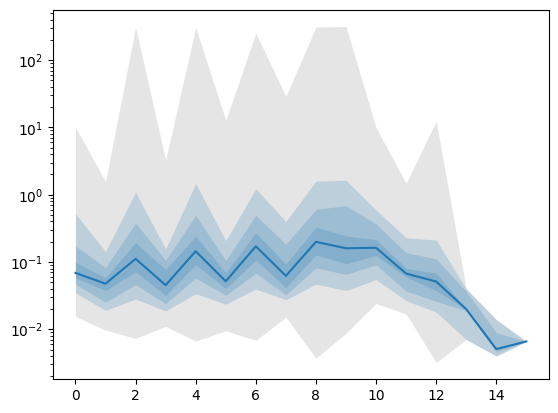

In [8]:
tot._plot_add_quantiles(x=np.arange(len(cb.ilr_stats[0])), data=cb.ilr_stats[0])
plt.yscale('log')
plt.show()

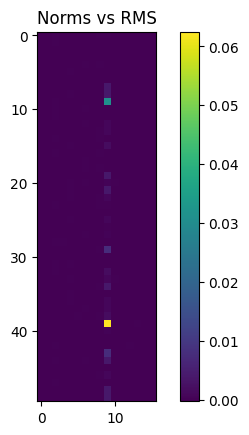

In [9]:
plt.title("Norms vs RMS")
plt.imshow(cb.ilr_norms - cb.ilr_rms)
plt.colorbar()
plt.show()

<ipython-input-10-45cdf80027a0>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(cb.ilr_norms - cb.ilr_rms)))


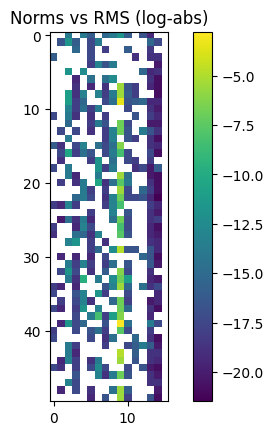

In [10]:
plt.title("Norms vs RMS (log-abs)")
plt.imshow(np.log(np.abs(cb.ilr_norms - cb.ilr_rms)))
plt.colorbar()
plt.show()

Observations:
* a size-normalized "euclidean" tensor norm is mathematically equivalent to computing the RMS of the tensor.
* In practice the discrepancies are generally very small, but for one of the variables the differences are noticeable.

In [15]:
# Function to benchmark execution time
def benchmark(fn, *args, n_iter=100):
    start = time.time()
    for _ in range(n_iter):
        _ = fn(*args)
    end = time.time()
    return (end - start) / n_iter  # Average time per iteration

# Generate a large tensor for testing
shape = (10000, 256)  # Large tensor for meaningful benchmarking
tensor = tf.random.normal(shape)

# Define scale computations
def compute_scale1(tensor):
    return tf.norm(tensor) / tf.sqrt(tf.cast(tf.size(tensor), dtype=tensor.dtype))

def compute_scale2(tensor):
    return tf.sqrt(tf.reduce_mean(tf.square(tensor)))

# Benchmark both methods
time_scale1 = benchmark(compute_scale1, tensor, n_iter=1000)
time_scale2 = benchmark(compute_scale2, tensor, n_iter=1000)

# Print results
print(f"Time per iteration (scale1): {time_scale1:.6f} sec")
print(f"Time per iteration (scale2): {time_scale2:.6f} sec")
print(f"scale1 compared to scale2: {time_scale1 / time_scale2:.2f}x")

Time per iteration (scale1): 0.001184 sec
Time per iteration (scale2): 0.000373 sec
scale1 compared to scale2: 3.17x


Observations:

```
# On CPU
Time per iteration (scale1): 0.003522 sec
Time per iteration (scale2): 0.002826 sec
scale1 compared to scale2: 1.25x

# On GPU
Time per iteration (scale1): 0.001168 sec
Time per iteration (scale2): 0.000297 sec
scale1 compared to scale2: 3.93x
```

So we're better of directly calculating RMS rather than the norm. Apparently RMS are significantly more efficient.

## Per-epoch calculations
As I've been experimenting with things I've found that the per-step results are pretty hard to make sense of. So here I'm attempting to calculate per-epoch values.

In [49]:
class LocalLearningRateHistoryCallback(tot.BaseGradientCallback):
    """
    ADAM optimizers and others that use momentum have an effective dynamic learning rate that is computed
    per-element and adapts to changes in the loss landscape during training. This callback attempts
    to calculate that "implicit" per-element learning rate, and then to collect stats across the learning
    rates for reporting.
    """
    def __init__(self, per_step=False, include_accurate=False, stats=True):
        """
        Args:
            stats: bool.
                Whether to collect percentile stats over per-element learning rates.
                Adds considerable time to training.
        """
        super().__init__()
        self.per_step = per_step
        self.include_accurate = include_accurate
        self.quantiles = [0., 12.5, 25., 37.5, 50., 62.5, 75., 87.5, 100.]

        # initially: list (by iteration) of list (by variable) of norm tensor
        # finally: list (by variable) of np-array with shape (iteration,)
        self._ilr_norms = []

        # TEMP
        self._ilr_norms_accurate = [] if include_accurate else None

        # initially: list (by iteration) of list (by variable) of percentiles tensor
        # finally: list (by variable) of pd-DataFrame with shape (iteration, percentile)
        self._ilr_stats = [] if stats else None

        # internal tracking
        self._variables_before_step = None
        self._variables_before_epoch = None
        self._gradients_accumulator = tot.PerEpochAccumulatorStrategy() if not per_step else None

    @property
    def ilr_norms(self):
        """
        A list (by trainable variable) of 1D-array (by iteration) containing the norms of the per-element
        "implicit learning rates". Norms are size-adjusted, effectively computing the RMS of the per-element values.
        """
        return self._ilr_norms

    @property
    def ilr_stats(self):
        """
        A list (by trainable variable) of pandas DataFrame, with shape (iteration, percentile), containining percentile
        stats over the per-element "implicit learning rates".
        None if not enabled.
        """
        return self._ilr_stats

    def on_train_end(self):
        def gather(iteration_item_data, v_idx):
            item_data = [iteration_values[v_idx] for iteration_values in iteration_item_data]
            return np.stack(item_data, axis=0)  # shape: (iterations, ...)

        # convert to final format
        num_vars = len(self._ilr_norms[0])
        self._ilr_norms = [gather(self._ilr_norms, v_idx) for v_idx in range(num_vars)]
        if self._ilr_norms_accurate is not None:
          self._ilr_norms_accurate = [gather(self._ilr_norms_accurate, v_idx) for v_idx in range(num_vars)]
        if self._ilr_stats is not None:
            self._ilr_stats = [pd.DataFrame(gather(self._ilr_stats, v_idx), columns=self.quantiles)
                               for v_idx in range(num_vars)]

        # free memory
        del self._variables_before_epoch
        del self._variables_before_step
        del self._gradients_accumulator

    def on_epoch_begin(self, epoch):
        self._variables_before_epoch = [tf.identity(v) for v in self.model.trainable_variables]

    def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
        # per-epoch
        if not self.per_step:
          implicit_learning_rates, ilr_norms = self._calculate(
              self._variables_before_epoch, self._gradients_accumulator.sum)
          self._ilr_norms.append(ilr_norms)
          if self._ilr_stats is not None:
              ilr_percentiles = [tfp.stats.percentile(ilr, self.quantiles) for ilr in implicit_learning_rates]
              self._ilr_stats.append(ilr_percentiles)

    def on_train_batch_begin(self, batch):
        self._variables_before_step = [tf.identity(v) for v in self.model.trainable_variables]

    def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
        # per-epoch mode only: accumulate gradients over course of epoch
        if not self.per_step:
            self._gradients_accumulator.accumulate(batch, gradients)

        if self.per_step or self.include_accurate:
            implicit_learning_rates, ilr_norms = self._calculate(self._variables_before_step, gradients)

            # per-step accurate calculations
            if self.include_accurate:
                self._ilr_norms_accurate.append(ilr_norms)

            # per-step calculations
            if self.per_step:
                self._ilr_norms.append(ilr_norms)
                if self._ilr_stats is not None:
                    ilr_percentiles = [tfp.stats.percentile(ilr, self.quantiles) for ilr in implicit_learning_rates]
                    self._ilr_stats.append(ilr_percentiles)

    def _calculate(self, variables_before, gradients):
        deltas = [after - before for after, before in zip(self.model.trainable_variables, variables_before)]
        implicit_learning_rates = [-delta / g for delta, g in zip(deltas, gradients)]
        implicit_learning_rates = [tf.gather_nd(ilr, tf.where(tf.math.is_finite(ilr))) for ilr in implicit_learning_rates]
        ilr_norms = [tf.sqrt(tf.reduce_mean(tf.square(ilr))) for ilr in implicit_learning_rates]
        return implicit_learning_rates, ilr_norms

def plot_lr_history_list(callback: LocalLearningRateHistoryCallback):
    # collect data
    model = callback.model
    num_items = len(callback.ilr_norms)
    collected_item_indices = tot.trainable_variable_indices_to_variable_indices(model)

    # Prepare display info
    item_display_names = []
    item_shapes = [model.variables[v_idx].shape for v_idx in collected_item_indices]
    layer_id_lookup = tot.layer_indices_by_variable(model)
    for v_idx in collected_item_indices:
        l_idx = layer_id_lookup[v_idx]
        layer_name = model.layers[l_idx].name
        variable_name = model.variables[v_idx].name
        item_display_names.append(f"{layer_name}(#{l_idx})/{variable_name}")

    plt.figure(figsize=(13, 4 * num_items / 2), layout='constrained')
    for i_idx in range(num_items):
        ylim = [np.min(callback._ilr_norms[i_idx]), np.max(callback._ilr_norms[i_idx])]
        if callback._ilr_norms_accurate is not None:
            ylim = [
                min(ylim[0], np.min(callback._ilr_norms_accurate[i_idx])),
                max(ylim[1], np.max(callback._ilr_norms_accurate[i_idx]))
            ]

        plt.subplot(num_items, 4, 1 + 4 * i_idx)
        plt.title(f"{item_display_names[i_idx]}: value")
        plt.margins(0)
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        tot._plot_add_quantiles(list(range(len(callback.ilr_norms[0]))), callback.ilr_stats[i_idx])
        plt.yscale("log")

        plt.subplot(num_items, 4, 2 + 4 * i_idx)
        plt.title("norms")
        plt.margins(0)
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        plt.plot(callback._ilr_norms[i_idx])
        plt.yscale("log")
        plt.ylim(ylim)

        if callback._ilr_norms_accurate is not None:
          data = callback._ilr_norms_accurate[i_idx]
          num_rows = callback._ilr_norms[i_idx].shape[0]
          batch_size = data.shape[0] // num_rows
          grouped = tf.reshape(data, [num_rows, batch_size, -1])
          data = tf.reduce_mean(grouped, axis=1)

          plt.subplot(num_items, 4, 3 + 4 * i_idx)
          plt.title("accurate norms")
          plt.margins(0)
          plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
          plt.plot(data)
          plt.yscale("log")
          plt.ylim(ylim)

        if callback._ilr_norms_accurate is not None:
          plt.subplot(num_items, 4, 4 + 4 * i_idx)
          plt.title("step norms")
          plt.margins(0)
          plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
          plt.plot(callback._ilr_norms_accurate[i_idx])
          plt.yscale("log")
          plt.ylim(ylim)

    plt.show()


In [18]:
reload(tot)
tf.config.run_functions_eagerly(False)

ilr = LocalLearningRateHistoryCallback(per_step=False, include_accurate=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr, tot.HistoryStats(per_step=True)])

Epoch    10 - 757.15ms/epoch: accuracy: 0.7333  binary_crossentropy: 0.5334  loss: 0.5334  mse: 0.1801  
Epoch    20 - 419.91ms/epoch: accuracy: 0.7933  binary_crossentropy: 0.4395  loss: 0.4395  mse: 0.1442  
Epoch    30 - 416.18ms/epoch: accuracy: 0.8133  binary_crossentropy: 0.4016  loss: 0.4016  mse: 0.1319  
Epoch    40 - 474.85ms/epoch: accuracy: 0.8933  binary_crossentropy: 0.2734  loss: 0.2734  mse: 0.0815  
Epoch    50 - 409.89ms/epoch: accuracy: 0.8933  binary_crossentropy: 0.2924  loss: 0.2924  mse: 0.0861  
Epoch    60 - 430.98ms/epoch: accuracy: 0.9000  binary_crossentropy: 0.2288  loss: 0.2288  mse: 0.0694  
Epoch    70 - 681.19ms/epoch: accuracy: 0.8933  binary_crossentropy: 0.2496  loss: 0.2496  mse: 0.0741  
Epoch    80 - 674.18ms/epoch: accuracy: 0.9033  binary_crossentropy: 0.2130  loss: 0.2130  mse: 0.0644  
Epoch    90 - 459.82ms/epoch: accuracy: 0.9300  binary_crossentropy: 0.1889  loss: 0.1889  mse: 0.0579  
Epoch   100 - 685.52ms/epoch: accuracy: 0.9400  binary_

In [33]:
print(f"ilr_norms:          {len(ilr.ilr_norms)} x {ilr.ilr_norms[0].shape}")
if ilr._ilr_norms_accurate is None:
  print(f"ilr_norms_accurate: None")
else:
  print(f"ilr_norms_accurate: {len(ilr._ilr_norms_accurate)} x {ilr._ilr_norms_accurate[0].shape}")
print(f"ilr_stats:          {len(ilr.ilr_stats)} x {type(ilr.ilr_stats[0])} x {ilr.ilr_stats[0].shape}")

ilr_norms:          16 x (100,)
ilr_norms_accurate: 16 x (1000,)
ilr_stats:          16 x <class 'pandas.core.frame.DataFrame'> x (100, 9)


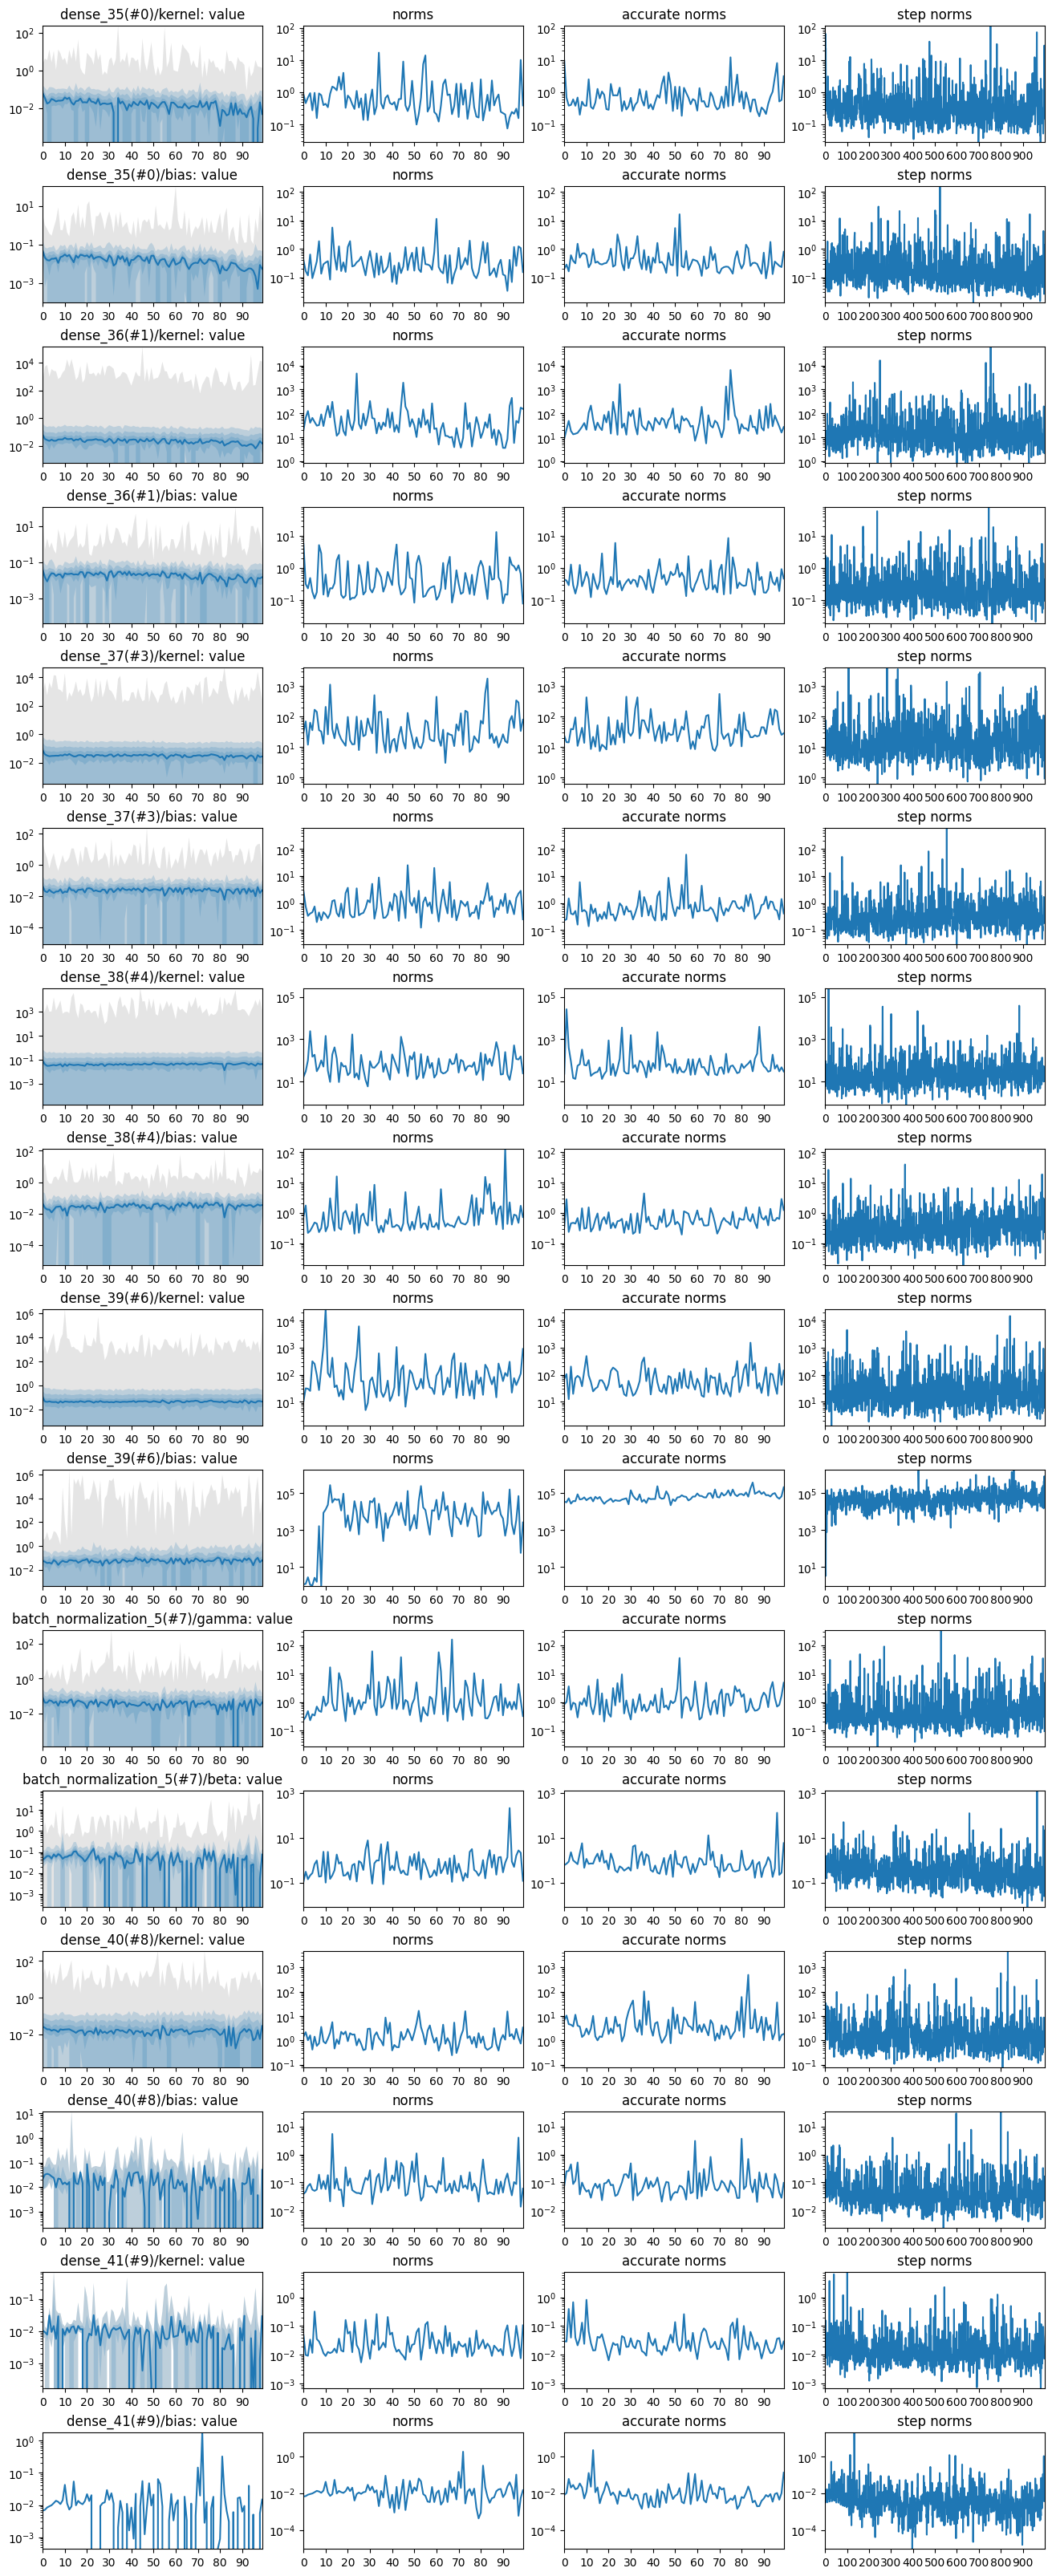

In [42]:
plot_lr_history_list(ilr)

Observations:

* The per-epoch calculated norms, and the per-epoch mean per-step norms are similar. There is one example of an extreme difference, and there's often differences in the spikes, but in general they approximately follow the same trend.
* So this looks like it'll be acceptable to calculate norms per-epoch as an approximation of the mean of the per-step learning rate norms.
* This means that we can do that if it's significantly more performant than calculating the norms per-step.


In [51]:
# Timing: calculating norms per-epoch, without stats
ilr = LocalLearningRateHistoryCallback(per_step=False, include_accurate=False, stats=False)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr])

Epoch    10 - 419.87ms/epoch: accuracy: 0.7300  binary_crossentropy: 0.5134  loss: 0.5134  mse: 0.1699  
Epoch    20 - 211.58ms/epoch: accuracy: 0.8133  binary_crossentropy: 0.4022  loss: 0.4022  mse: 0.1265  
Epoch    30 - 119.53ms/epoch: accuracy: 0.8233  binary_crossentropy: 0.3717  loss: 0.3717  mse: 0.1200  
Epoch    40 - 116.45ms/epoch: accuracy: 0.8733  binary_crossentropy: 0.2722  loss: 0.2722  mse: 0.0846  
Epoch    50 - 125.95ms/epoch: accuracy: 0.9100  binary_crossentropy: 0.2161  loss: 0.2161  mse: 0.0623  
Epoch    60 - 116.38ms/epoch: accuracy: 0.9433  binary_crossentropy: 0.1800  loss: 0.1800  mse: 0.0513  
Epoch    70 - 116.75ms/epoch: accuracy: 0.9133  binary_crossentropy: 0.2049  loss: 0.2049  mse: 0.0618  
Epoch    80 - 119.47ms/epoch: accuracy: 0.9200  binary_crossentropy: 0.2039  loss: 0.2039  mse: 0.0610  
Epoch    90 - 122.26ms/epoch: accuracy: 0.9200  binary_crossentropy: 0.2082  loss: 0.2082  mse: 0.0632  
Epoch   100 - 160.98ms/epoch: accuracy: 0.9467  binary_

In [50]:
# Timing: calculating norms per-step, without stats
ilr = LocalLearningRateHistoryCallback(per_step=True, include_accurate=False, stats=False)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr])

Epoch    10 - 552.79ms/epoch: accuracy: 0.7533  binary_crossentropy: 0.5463  loss: 0.5463  mse: 0.1846  
Epoch    20 - 255.77ms/epoch: accuracy: 0.7867  binary_crossentropy: 0.4452  loss: 0.4452  mse: 0.1448  
Epoch    30 - 260.97ms/epoch: accuracy: 0.8333  binary_crossentropy: 0.3556  loss: 0.3556  mse: 0.1124  
Epoch    40 - 325.50ms/epoch: accuracy: 0.8667  binary_crossentropy: 0.3360  loss: 0.3360  mse: 0.1051  
Epoch    50 - 259.91ms/epoch: accuracy: 0.8833  binary_crossentropy: 0.2948  loss: 0.2948  mse: 0.0934  
Epoch    60 - 258.75ms/epoch: accuracy: 0.9033  binary_crossentropy: 0.2156  loss: 0.2156  mse: 0.0662  
Epoch    70 - 255.53ms/epoch: accuracy: 0.8967  binary_crossentropy: 0.2431  loss: 0.2431  mse: 0.0752  
Epoch    80 - 349.15ms/epoch: accuracy: 0.9267  binary_crossentropy: 0.2057  loss: 0.2057  mse: 0.0558  
Epoch    90 - 262.88ms/epoch: accuracy: 0.9200  binary_crossentropy: 0.2044  loss: 0.2044  mse: 0.0611  
Epoch   100 - 256.88ms/epoch: accuracy: 0.9500  binary_

Observations:

```
# GPU per-epoch
Epoch    10 - 419.87ms/epoch: accuracy: 0.7300  binary_crossentropy: 0.5134  loss: 0.5134  mse: 0.1699  
Epoch    20 - 211.58ms/epoch: accuracy: 0.8133  binary_crossentropy: 0.4022  loss: 0.4022  mse: 0.1265  
Epoch    30 - 119.53ms/epoch: accuracy: 0.8233  binary_crossentropy: 0.3717  loss: 0.3717  mse: 0.1200  
Epoch    40 - 116.45ms/epoch: accuracy: 0.8733  binary_crossentropy: 0.2722  loss: 0.2722  mse: 0.0846  
Epoch    50 - 125.95ms/epoch: accuracy: 0.9100  binary_crossentropy: 0.2161  loss: 0.2161  mse: 0.0623  
Epoch    60 - 116.38ms/epoch: accuracy: 0.9433  binary_crossentropy: 0.1800  loss: 0.1800  mse: 0.0513  
Epoch    70 - 116.75ms/epoch: accuracy: 0.9133  binary_crossentropy: 0.2049  loss: 0.2049  mse: 0.0618  
Epoch    80 - 119.47ms/epoch: accuracy: 0.9200  binary_crossentropy: 0.2039  loss: 0.2039  mse: 0.0610  
Epoch    90 - 122.26ms/epoch: accuracy: 0.9200  binary_crossentropy: 0.2082  loss: 0.2082  mse: 0.0632  
Epoch   100 - 160.98ms/epoch: accuracy: 0.9467  binary_crossentropy: 0.1549  loss: 0.1549  mse: 0.0439

# GPU per-step
Epoch    10 - 552.79ms/epoch: accuracy: 0.7533  binary_crossentropy: 0.5463  loss: 0.5463  mse: 0.1846  
Epoch    20 - 255.77ms/epoch: accuracy: 0.7867  binary_crossentropy: 0.4452  loss: 0.4452  mse: 0.1448  
Epoch    30 - 260.97ms/epoch: accuracy: 0.8333  binary_crossentropy: 0.3556  loss: 0.3556  mse: 0.1124  
Epoch    40 - 325.50ms/epoch: accuracy: 0.8667  binary_crossentropy: 0.3360  loss: 0.3360  mse: 0.1051  
Epoch    50 - 259.91ms/epoch: accuracy: 0.8833  binary_crossentropy: 0.2948  loss: 0.2948  mse: 0.0934  
Epoch    60 - 258.75ms/epoch: accuracy: 0.9033  binary_crossentropy: 0.2156  loss: 0.2156  mse: 0.0662  
Epoch    70 - 255.53ms/epoch: accuracy: 0.8967  binary_crossentropy: 0.2431  loss: 0.2431  mse: 0.0752  
Epoch    80 - 349.15ms/epoch: accuracy: 0.9267  binary_crossentropy: 0.2057  loss: 0.2057  mse: 0.0558  
Epoch    90 - 262.88ms/epoch: accuracy: 0.9200  binary_crossentropy: 0.2044  loss: 0.2044  mse: 0.0611  
Epoch   100 - 256.88ms/epoch: accuracy: 0.9500  binary_crossentropy: 0.1324  loss: 0.1324  mse: 0.0367
```

* Even with the need to accumulate gradients per-step, calculating the norms per-epoch is still about 2.x faster (300ms/120ms for typical epoch times).
* So we'll implement per-epoch mode by accumulating gradients and estimating the per-epoch learning rates.


## Revised standard observability results
Finally, let's run the newly created and revised library callback.

In [33]:
reload(tot)
tf.config.run_functions_eagerly(False)

ilr_per_step = tot.LearningRateHistoryCallback(per_step=True)
ilr_per_epoch = tot.LearningRateHistoryCallback(per_step=False)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr_per_step, ilr_per_epoch])

Epoch    10 - 1.09s/epoch: accuracy: 0.7833  binary_crossentropy: 0.5081  loss: 0.5081  mse: 0.1667  
Epoch    20 - 768.03ms/epoch: accuracy: 0.8100  binary_crossentropy: 0.4263  loss: 0.4263  mse: 0.1391  
Epoch    30 - 816.75ms/epoch: accuracy: 0.8567  binary_crossentropy: 0.3310  loss: 0.3310  mse: 0.1029  
Epoch    40 - 771.04ms/epoch: accuracy: 0.8800  binary_crossentropy: 0.2888  loss: 0.2888  mse: 0.0867  
Epoch    50 - 708.25ms/epoch: accuracy: 0.9100  binary_crossentropy: 0.2554  loss: 0.2554  mse: 0.0744  
Epoch    60 - 817.72ms/epoch: accuracy: 0.8933  binary_crossentropy: 0.2439  loss: 0.2439  mse: 0.0742  
Epoch    70 - 690.94ms/epoch: accuracy: 0.9167  binary_crossentropy: 0.1828  loss: 0.1828  mse: 0.0535  
Epoch    80 - 722.11ms/epoch: accuracy: 0.9067  binary_crossentropy: 0.1982  loss: 0.1982  mse: 0.0611  
Epoch    90 - 727.73ms/epoch: accuracy: 0.9333  binary_crossentropy: 0.1593  loss: 0.1593  mse: 0.0490  
Epoch   100 - 674.98ms/epoch: accuracy: 0.9567  binary_cro

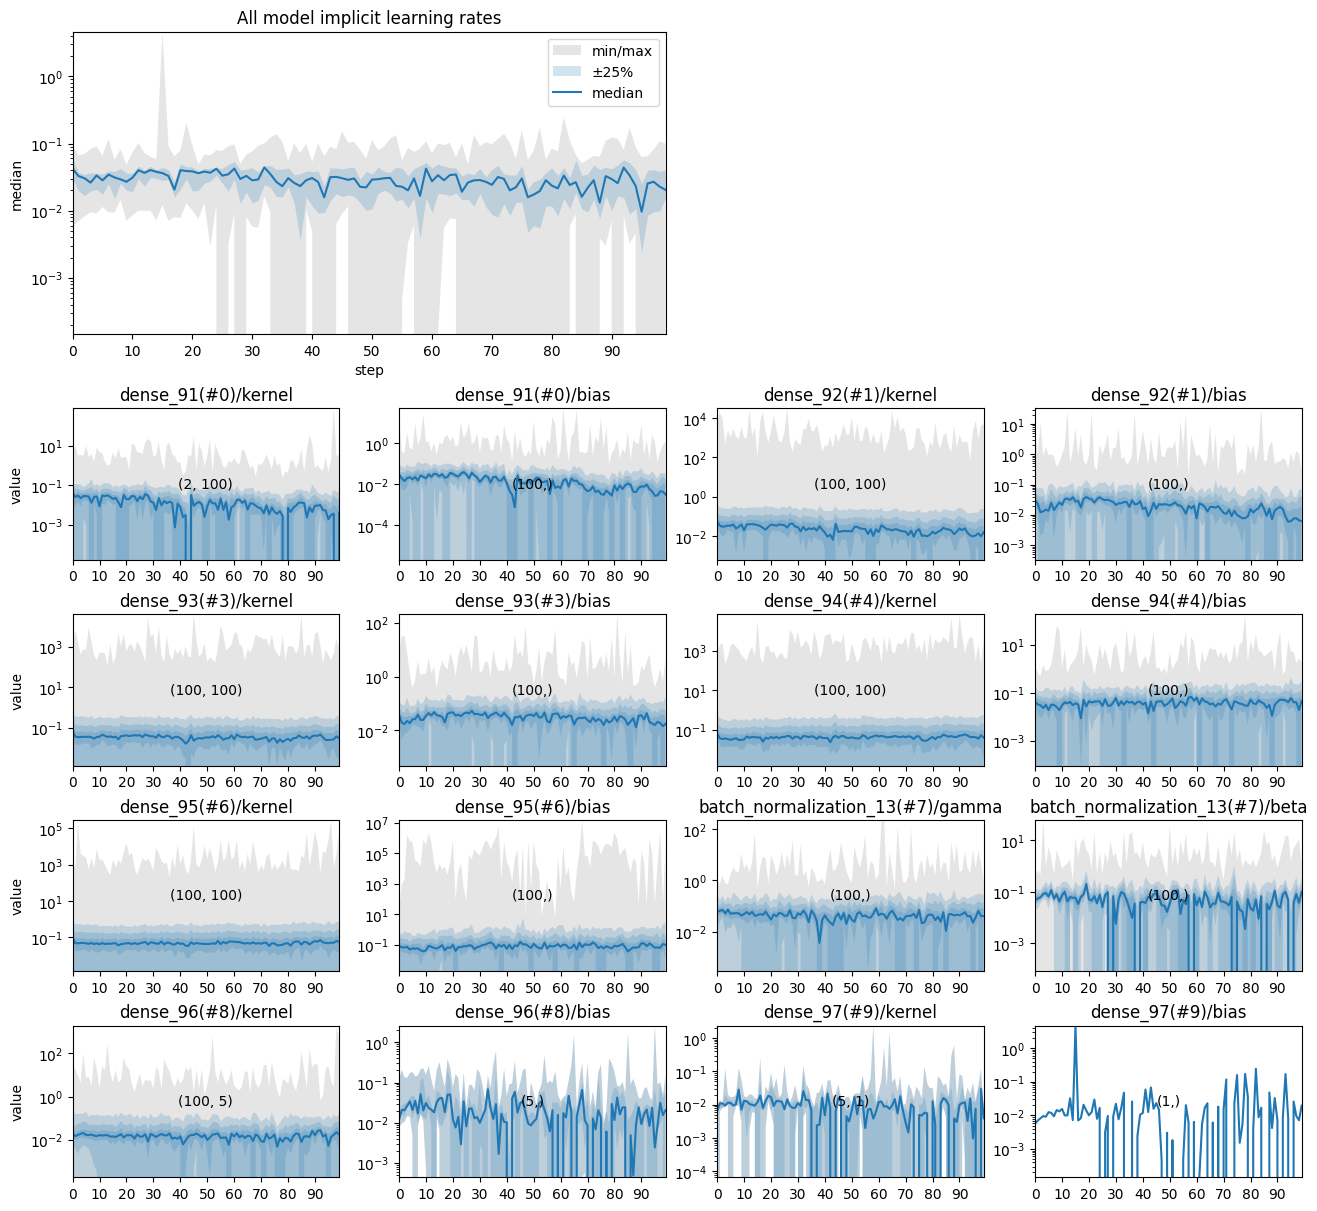

In [39]:
tot.plot_lr_history(ilr_per_epoch)

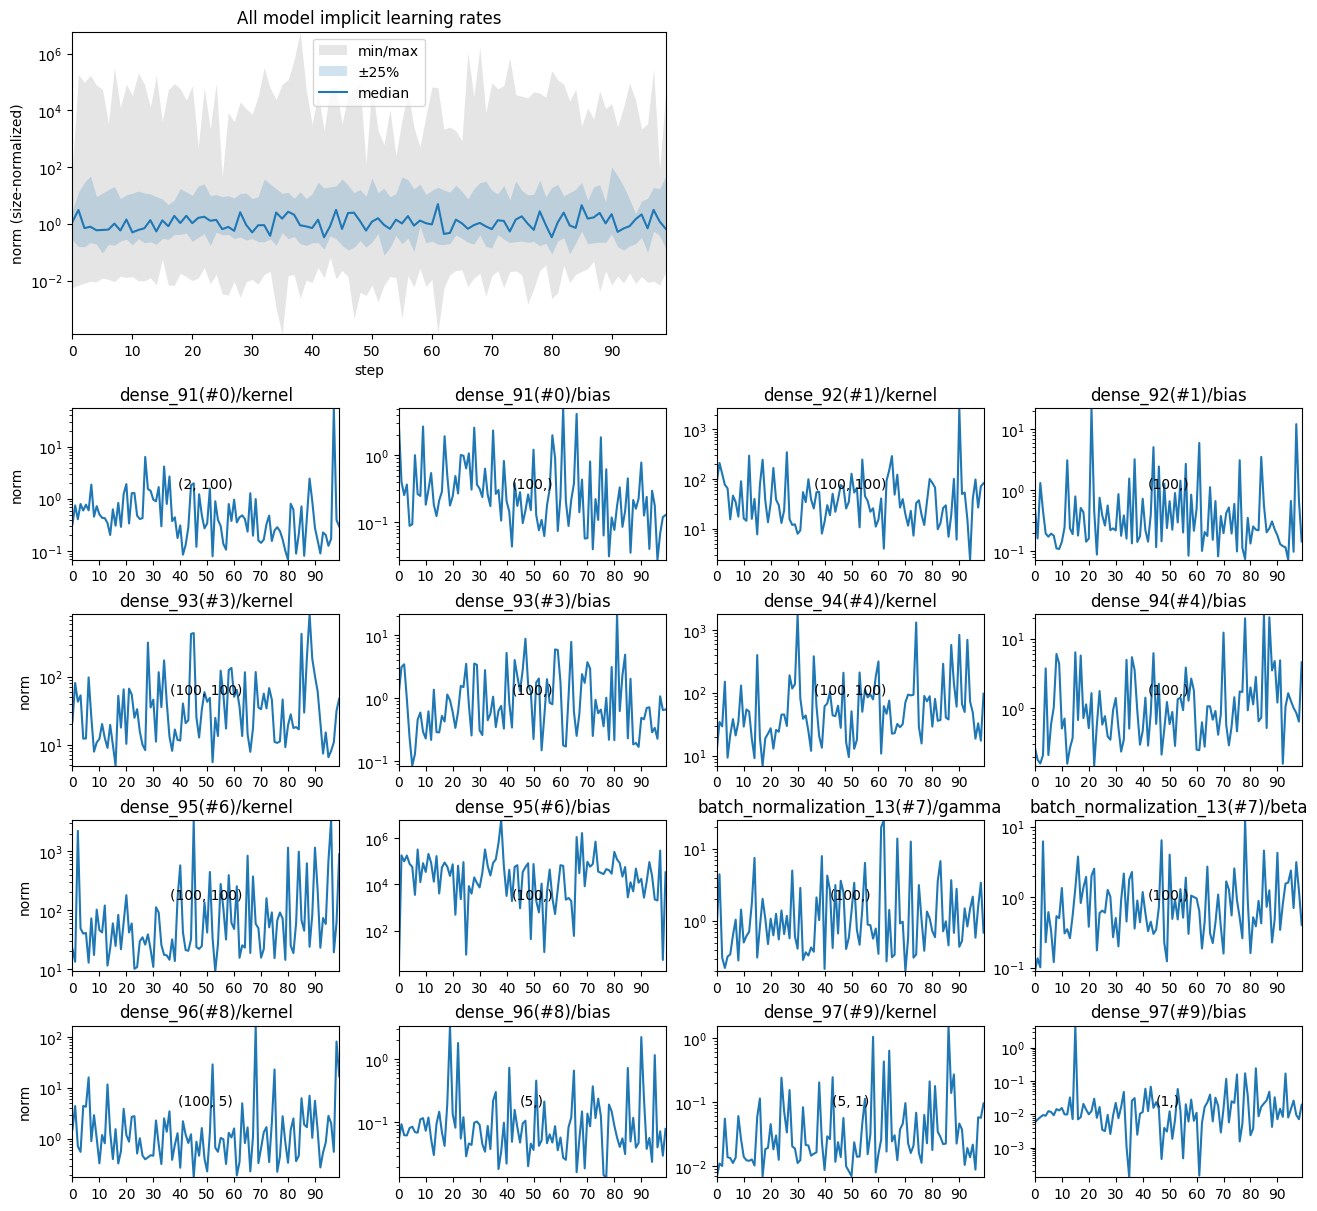

In [40]:
tot.plot_lr_history(ilr_per_epoch, show='norms')

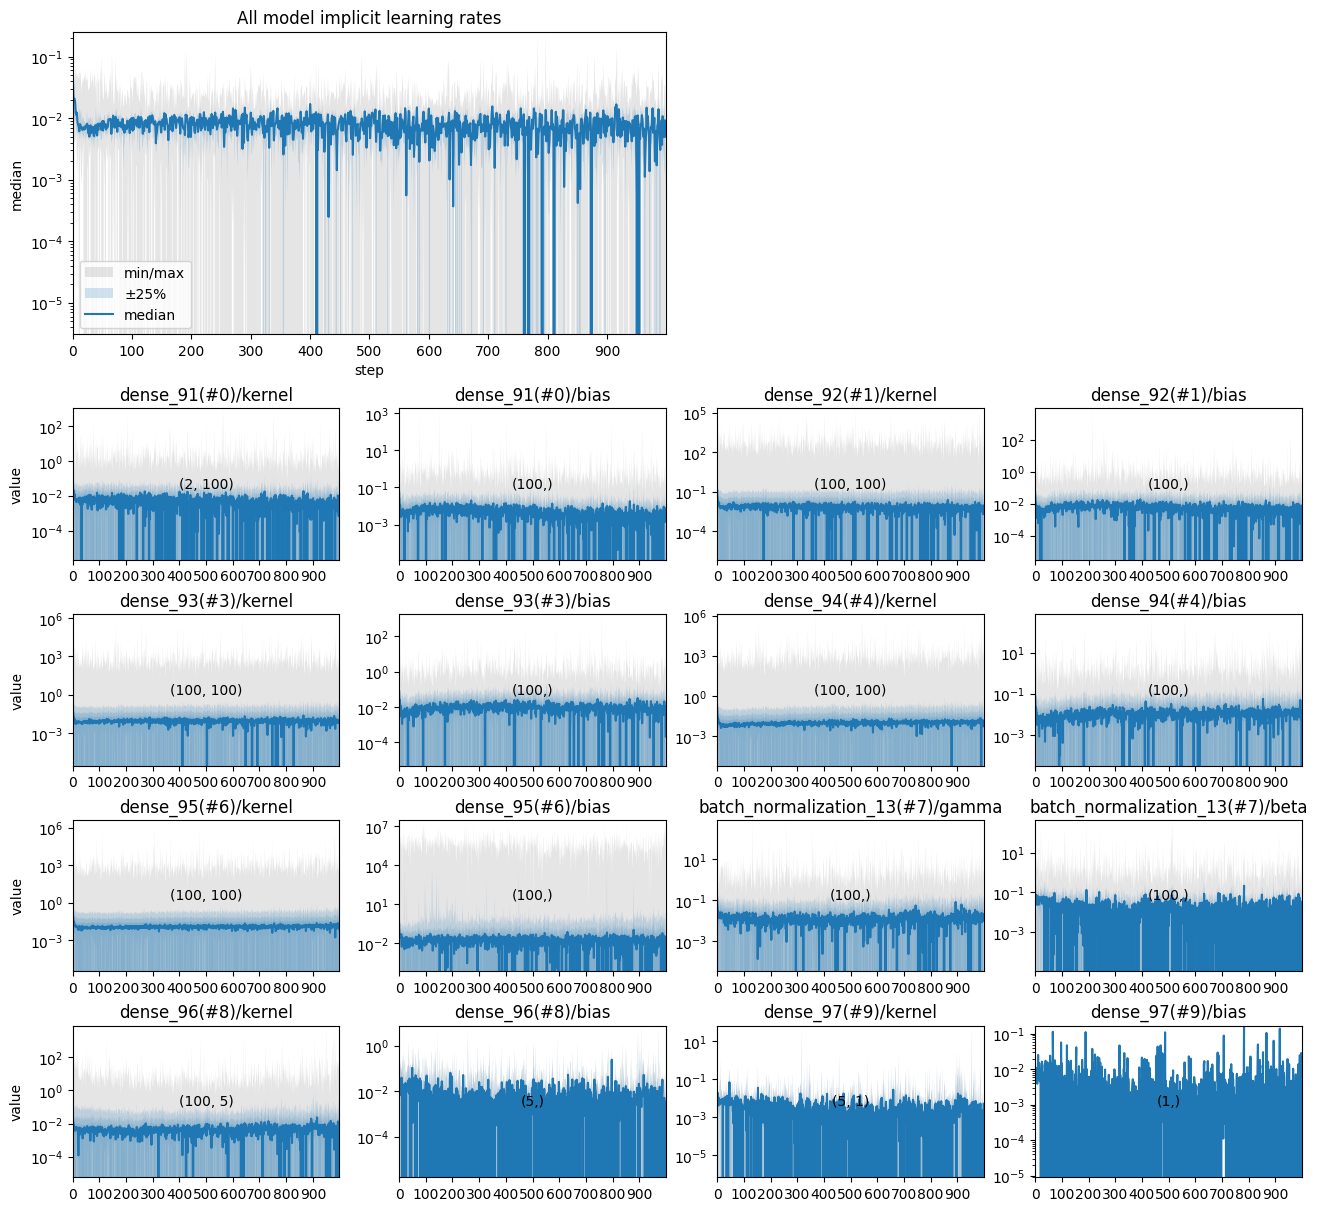

In [41]:
tot.plot_lr_history(ilr_per_step)

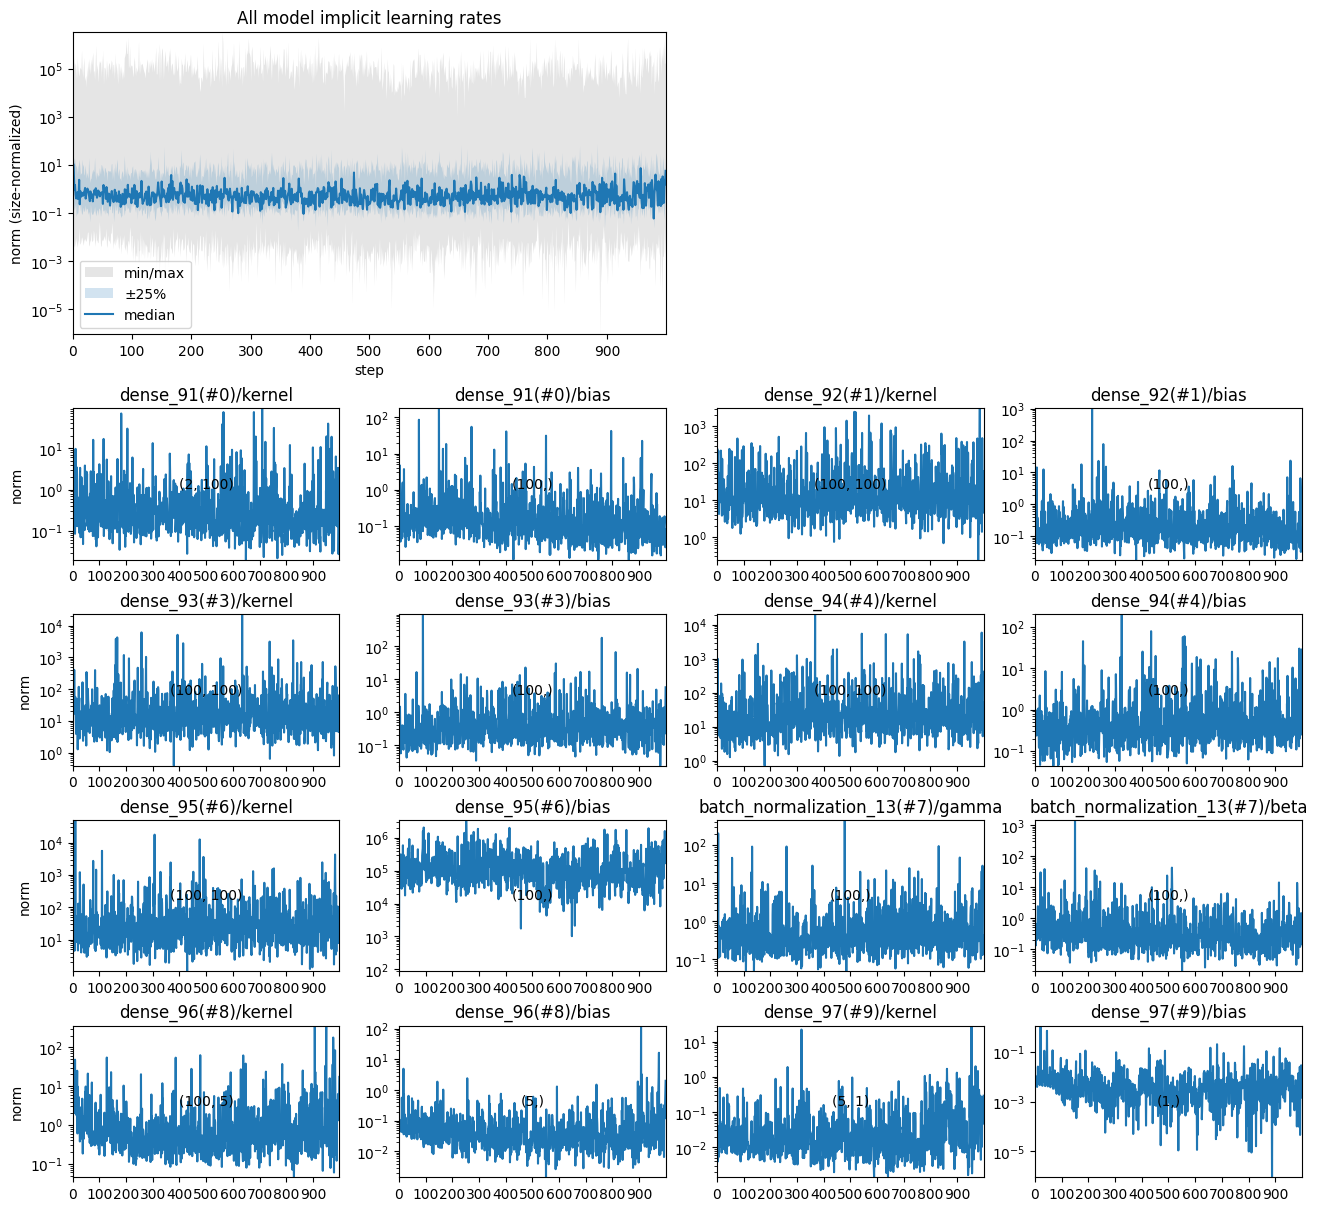

In [42]:
tot.plot_lr_history(ilr_per_step, show='norms')

## With simple SGD

In [44]:
reload(tot)
tf.config.run_functions_eagerly(False)

ilr = tot.LearningRateHistoryCallback(per_step=False)
model = binary_classification_model('he_normal')
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr])

Epoch    10 - 201.27ms/epoch: accuracy: 0.5600  binary_crossentropy: 0.7368  loss: 0.7368  mse: 0.2640  
Epoch    20 - 102.31ms/epoch: accuracy: 0.6133  binary_crossentropy: 0.6560  loss: 0.6560  mse: 0.2314  
Epoch    30 - 91.56ms/epoch: accuracy: 0.6867  binary_crossentropy: 0.6215  loss: 0.6215  mse: 0.2155  
Epoch    40 - 92.29ms/epoch: accuracy: 0.7400  binary_crossentropy: 0.5854  loss: 0.5854  mse: 0.1988  
Epoch    50 - 96.19ms/epoch: accuracy: 0.7500  binary_crossentropy: 0.5589  loss: 0.5589  mse: 0.1874  
Epoch    60 - 92.05ms/epoch: accuracy: 0.7300  binary_crossentropy: 0.5581  loss: 0.5581  mse: 0.1855  
Epoch    70 - 89.51ms/epoch: accuracy: 0.7767  binary_crossentropy: 0.5038  loss: 0.5038  mse: 0.1654  
Epoch    80 - 90.09ms/epoch: accuracy: 0.7833  binary_crossentropy: 0.4819  loss: 0.4819  mse: 0.1590  
Epoch    90 - 97.88ms/epoch: accuracy: 0.8233  binary_crossentropy: 0.4311  loss: 0.4311  mse: 0.1384  
Epoch   100 - 147.73ms/epoch: accuracy: 0.8167  binary_crossen

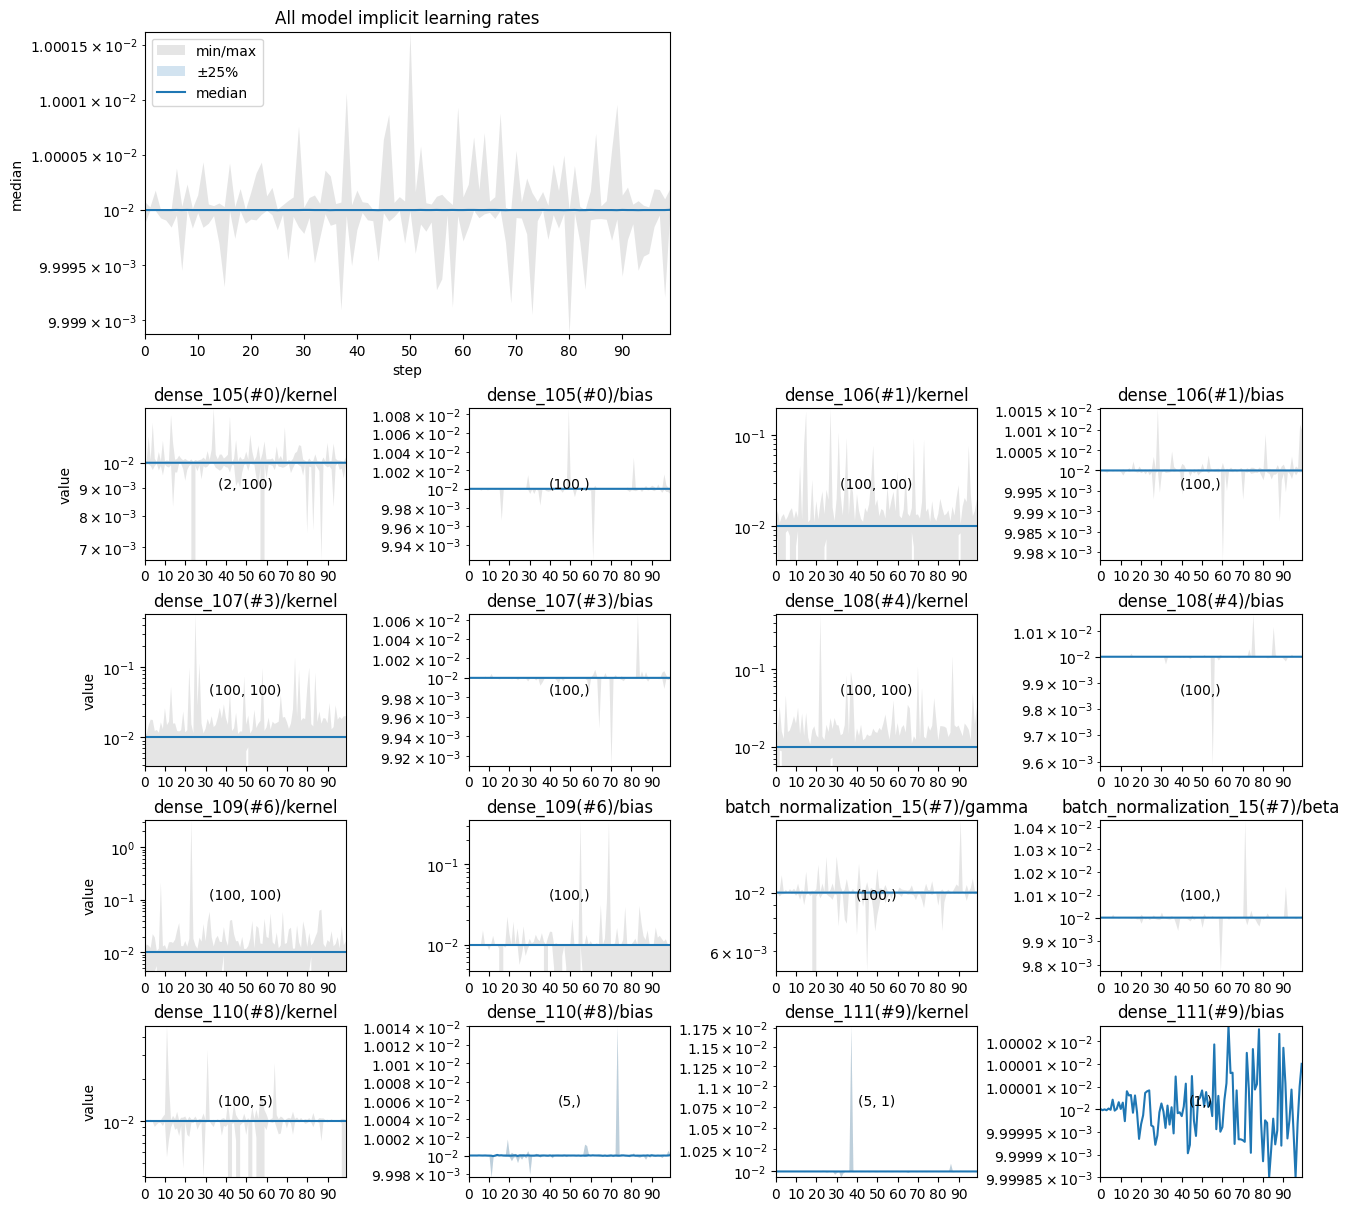

In [46]:
# aside from some numerical stability, we get a constant 0.01 learning rate throughout.
tot.plot_lr_history(ilr)

## SGD with varying learning rate

In [62]:
reload(tot)
tf.config.run_functions_eagerly(False)

ilr = tot.LearningRateHistoryCallback(per_step=False)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100, # decay in steps every 10 epochs
    decay_rate=0.9,
    staircase=True)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

model = binary_classification_model('he_normal')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr])

Epoch    10 - 270.93ms/epoch: accuracy: 0.6867  binary_crossentropy: 0.5989  loss: 0.5989  mse: 0.2076  
Epoch    20 - 92.67ms/epoch: accuracy: 0.7533  binary_crossentropy: 0.5385  loss: 0.5385  mse: 0.1818  
Epoch    30 - 98.13ms/epoch: accuracy: 0.8167  binary_crossentropy: 0.4637  loss: 0.4637  mse: 0.1499  
Epoch    40 - 89.03ms/epoch: accuracy: 0.7767  binary_crossentropy: 0.4576  loss: 0.4576  mse: 0.1501  
Epoch    50 - 90.75ms/epoch: accuracy: 0.8200  binary_crossentropy: 0.3965  loss: 0.3965  mse: 0.1255  
Epoch    60 - 89.54ms/epoch: accuracy: 0.7700  binary_crossentropy: 0.4491  loss: 0.4491  mse: 0.1476  
Epoch    70 - 97.66ms/epoch: accuracy: 0.8067  binary_crossentropy: 0.4286  loss: 0.4286  mse: 0.1388  
Epoch    80 - 93.10ms/epoch: accuracy: 0.8167  binary_crossentropy: 0.4124  loss: 0.4124  mse: 0.1328  
Epoch    90 - 119.19ms/epoch: accuracy: 0.8200  binary_crossentropy: 0.3965  loss: 0.3965  mse: 0.1259  
Epoch   100 - 263.58ms/epoch: accuracy: 0.8467  binary_crossen

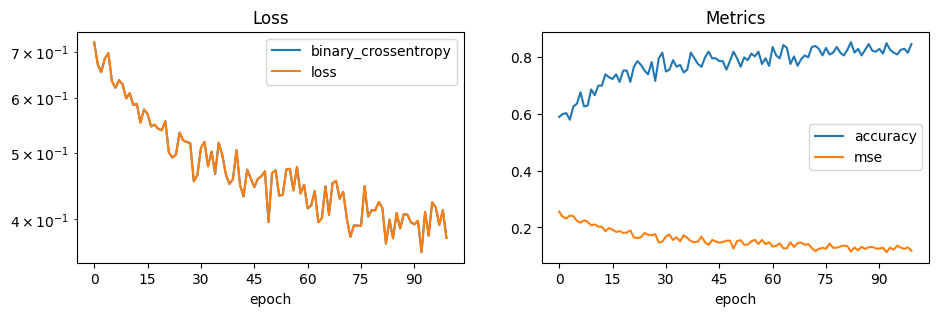

In [63]:
tot.plot_train_history(history)

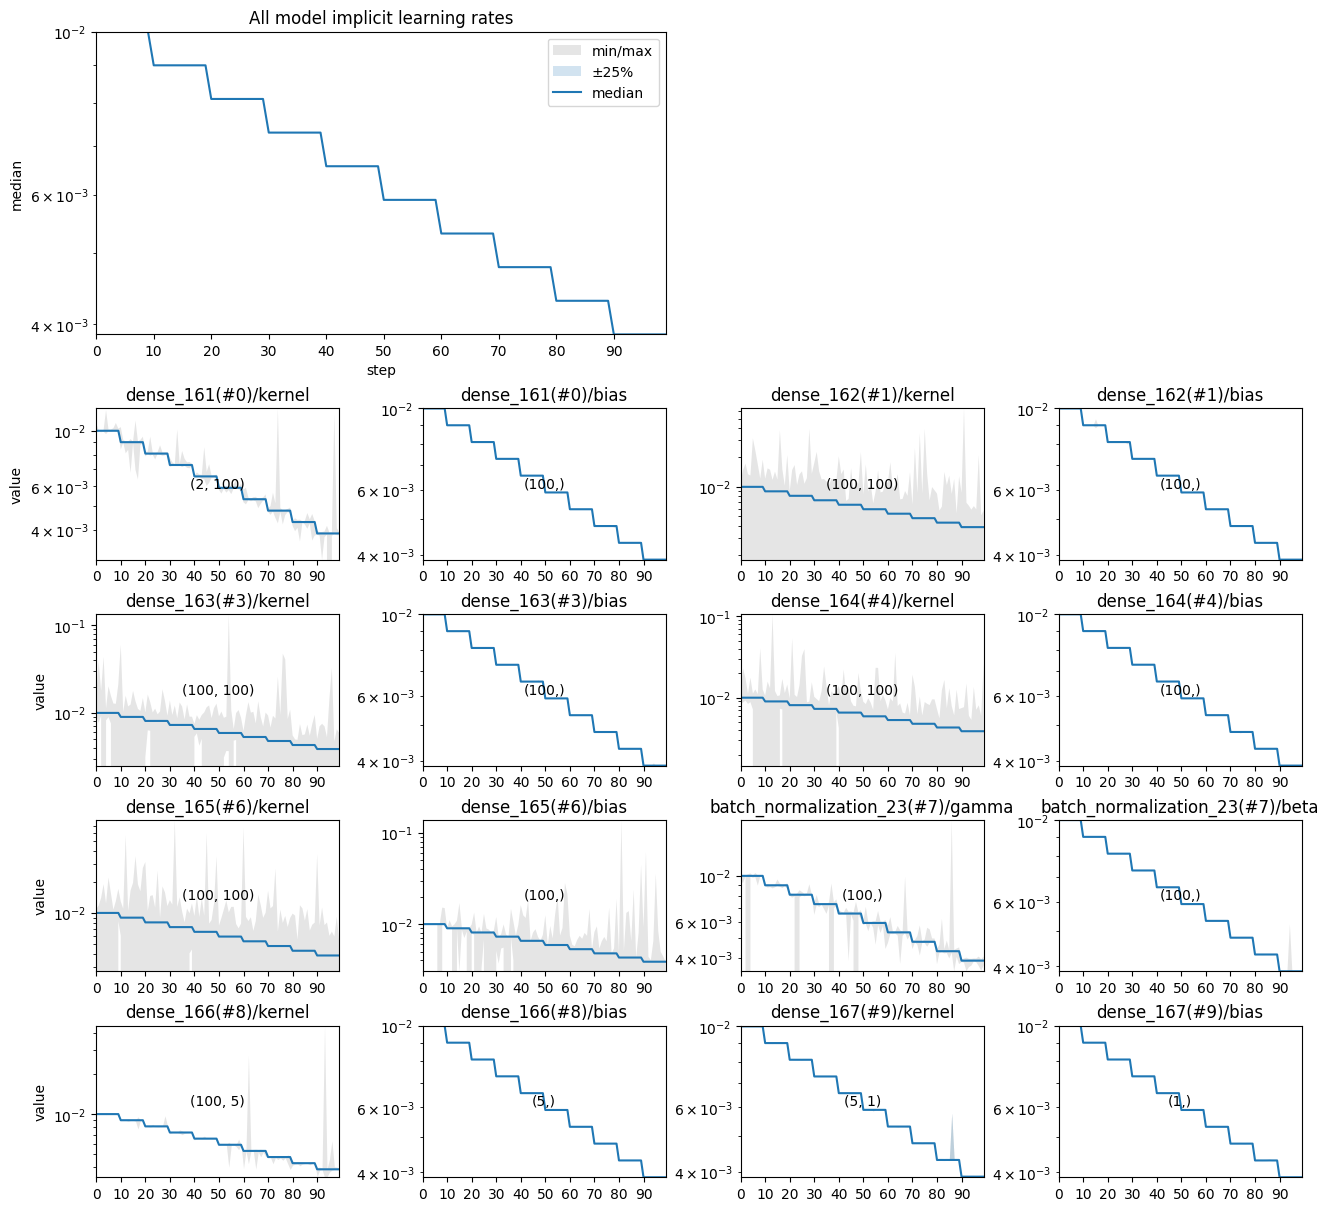

In [64]:
tot.plot_lr_history(ilr)

## Adam with varying learning rate

In [65]:
reload(tot)
tf.config.run_functions_eagerly(False)

ilr = tot.LearningRateHistoryCallback(per_step=False)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100, # decay in steps every 10 epochs
    decay_rate=0.9,
    staircase=True)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model = binary_classification_model('he_normal')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr])

Epoch    10 - 334.27ms/epoch: accuracy: 0.8300  binary_crossentropy: 0.4096  loss: 0.4096  mse: 0.1260  
Epoch    20 - 97.00ms/epoch: accuracy: 0.9300  binary_crossentropy: 0.1922  loss: 0.1922  mse: 0.0543  
Epoch    30 - 99.42ms/epoch: accuracy: 0.9500  binary_crossentropy: 0.0967  loss: 0.0967  mse: 0.0301  
Epoch    40 - 97.98ms/epoch: accuracy: 0.9400  binary_crossentropy: 0.1194  loss: 0.1194  mse: 0.0397  
Epoch    50 - 92.85ms/epoch: accuracy: 0.9600  binary_crossentropy: 0.0938  loss: 0.0938  mse: 0.0281  
Epoch    60 - 93.60ms/epoch: accuracy: 0.9733  binary_crossentropy: 0.0704  loss: 0.0704  mse: 0.0208  
Epoch    70 - 98.06ms/epoch: accuracy: 0.9867  binary_crossentropy: 0.0411  loss: 0.0411  mse: 0.0108  
Epoch    80 - 116.39ms/epoch: accuracy: 0.9833  binary_crossentropy: 0.0432  loss: 0.0432  mse: 0.0129  
Epoch    90 - 113.04ms/epoch: accuracy: 0.9967  binary_crossentropy: 0.0320  loss: 0.0320  mse: 0.0067  
Epoch   100 - 91.27ms/epoch: accuracy: 0.9933  binary_crossen

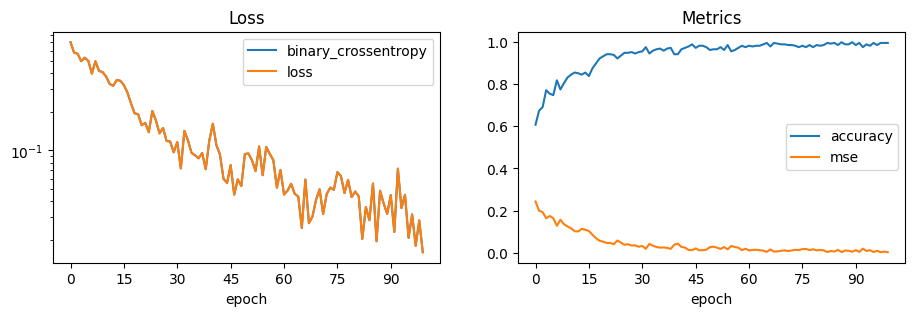

In [67]:
tot.plot_train_history(history)

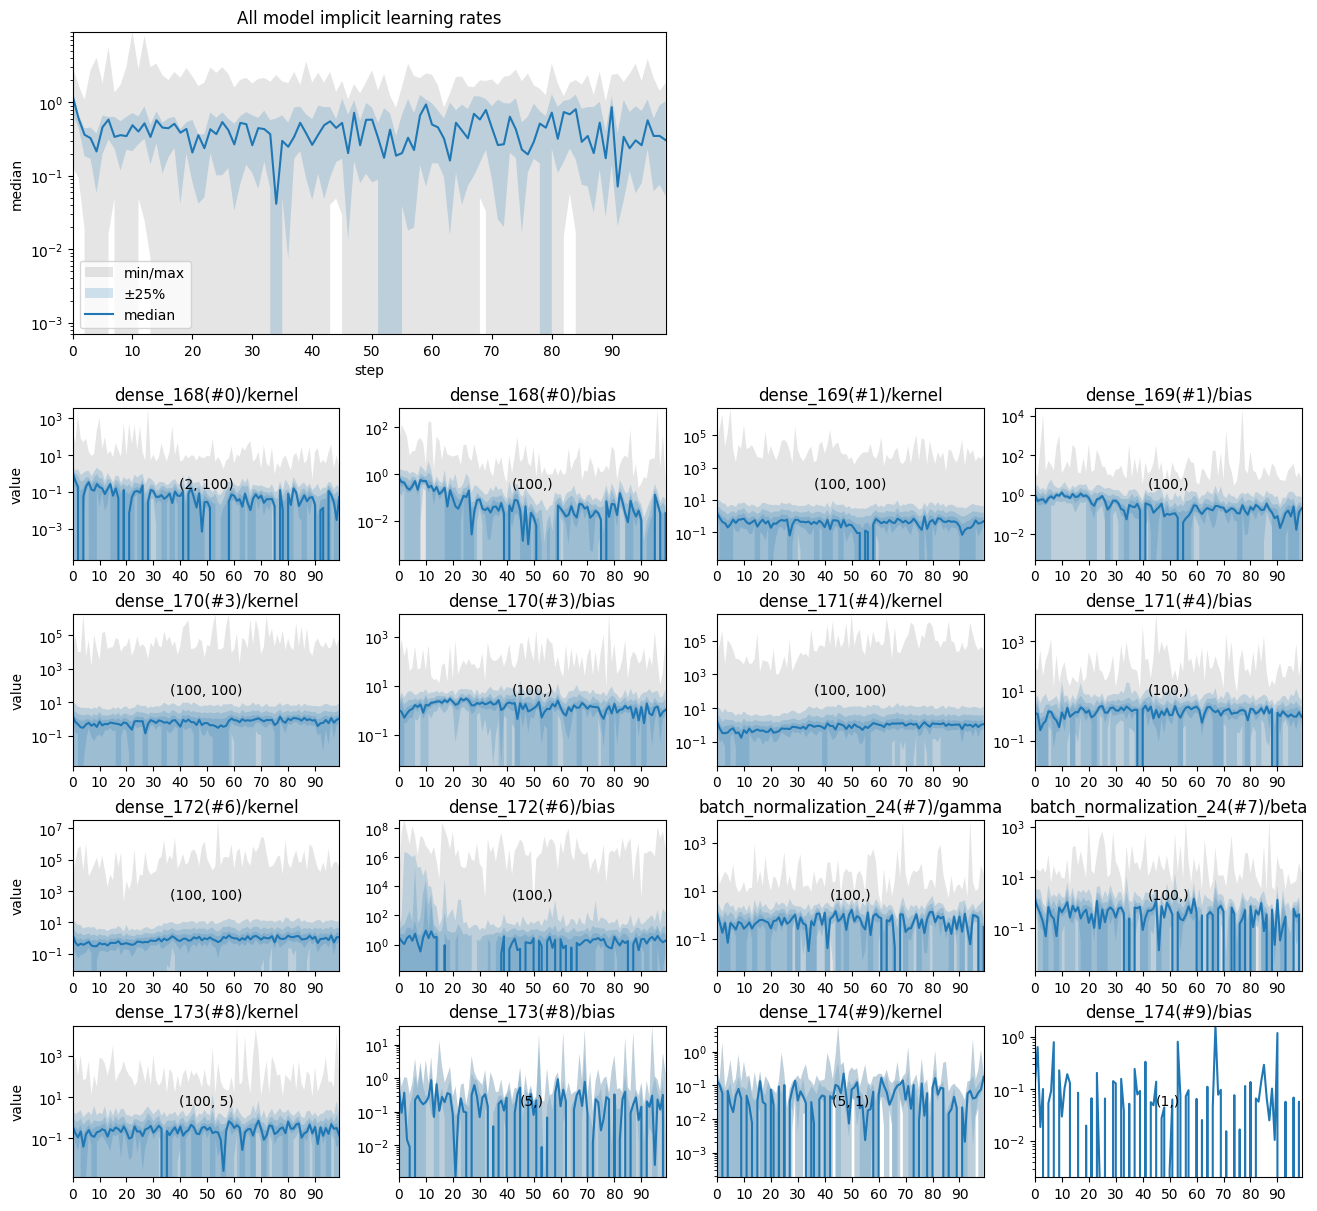

In [66]:
tot.plot_lr_history(ilr)

A slow learning rate decay gets counteracted by Adam's automatic scaling. Need to make the learning rate decay faster for it to take effect...

Epoch    10 - 434.76ms/epoch: accuracy: 0.8600  binary_crossentropy: 0.3374  loss: 0.3374  mse: 0.1049  
Epoch    20 - 88.95ms/epoch: accuracy: 0.8467  binary_crossentropy: 0.3502  loss: 0.3502  mse: 0.1101  
Epoch    30 - 99.64ms/epoch: accuracy: 0.9033  binary_crossentropy: 0.2607  loss: 0.2607  mse: 0.0774  
Epoch    40 - 97.19ms/epoch: accuracy: 0.9000  binary_crossentropy: 0.2516  loss: 0.2516  mse: 0.0779  
Epoch    50 - 91.95ms/epoch: accuracy: 0.8900  binary_crossentropy: 0.2578  loss: 0.2578  mse: 0.0777  
Epoch    60 - 95.26ms/epoch: accuracy: 0.9167  binary_crossentropy: 0.2010  loss: 0.2010  mse: 0.0588  
Epoch    70 - 89.77ms/epoch: accuracy: 0.8767  binary_crossentropy: 0.2775  loss: 0.2775  mse: 0.0869  
Epoch    80 - 89.39ms/epoch: accuracy: 0.9000  binary_crossentropy: 0.2299  loss: 0.2299  mse: 0.0697  
Epoch    90 - 100.76ms/epoch: accuracy: 0.8667  binary_crossentropy: 0.2679  loss: 0.2679  mse: 0.0850  
Epoch   100 - 96.69ms/epoch: accuracy: 0.8700  binary_crossent

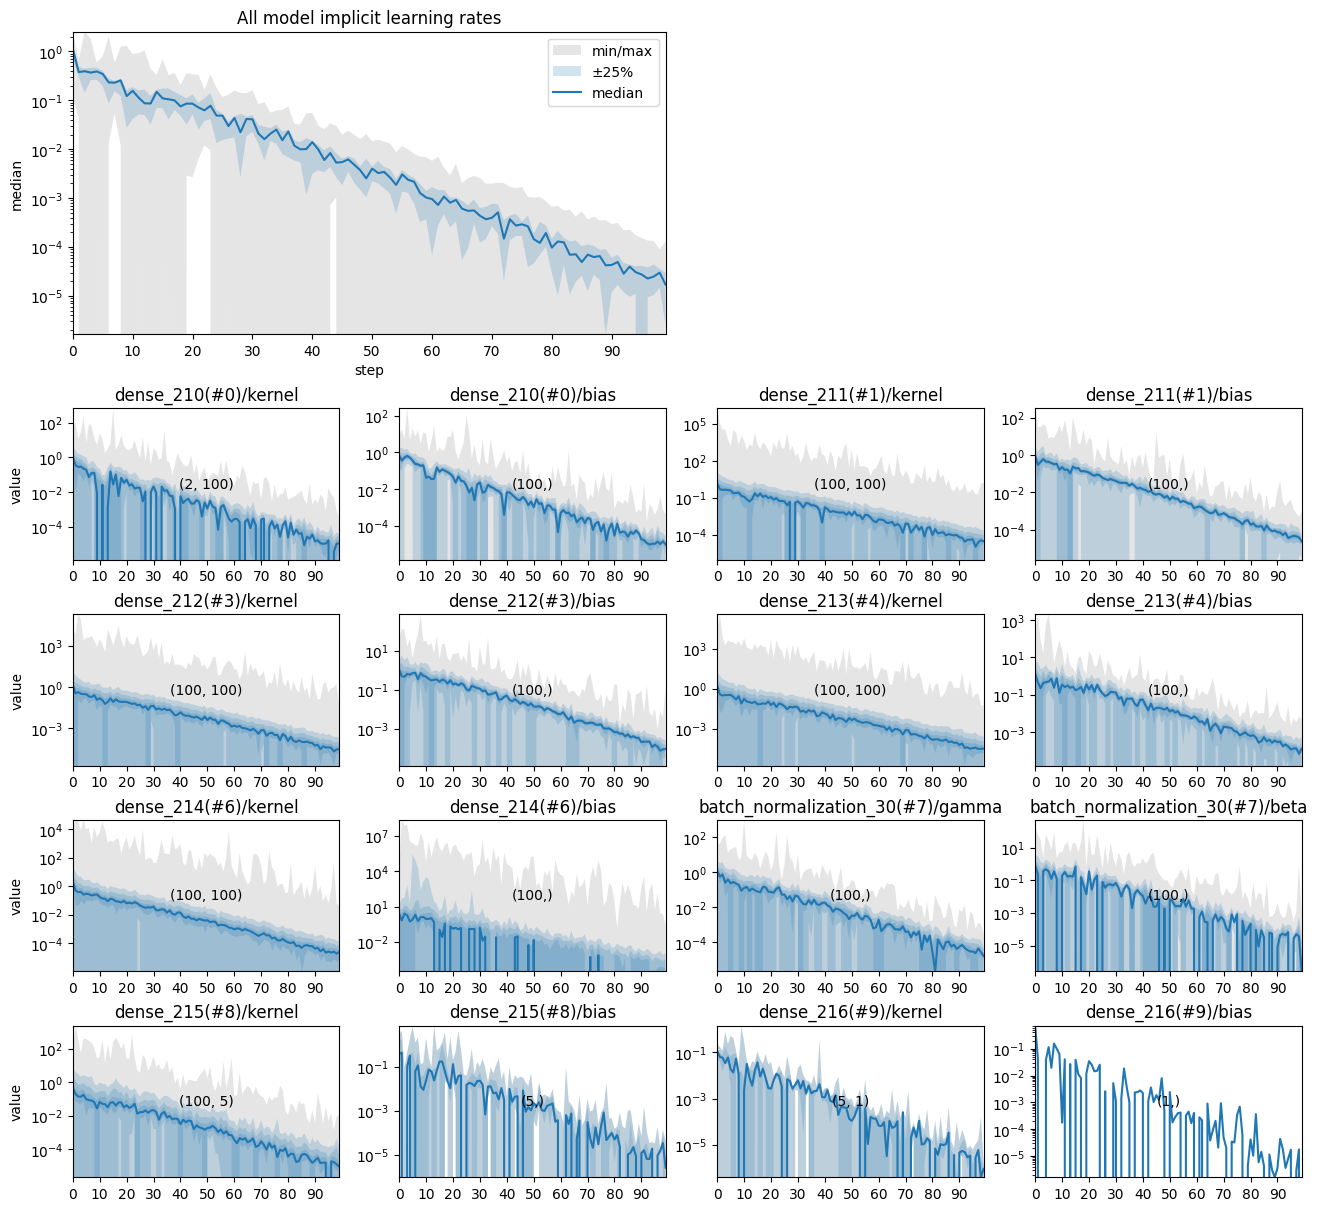

In [73]:
ilr = tot.LearningRateHistoryCallback(per_step=False)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model = binary_classification_model('he_normal')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), ilr])

tot.plot_lr_history(ilr)

## Conclusions
* Calculating and making intuitive sense of the _implicit learning rate_ tensors is difficult. The best result appears to be from using the _medians_ of each variable's ILR tensor.
* In contrast, the RMS value focuses too much on large outliers. For example, it's quite common to get individual elements with implicit learning rates in the magnitude of 10 to 100. RMS drastically emphasises those.
* Even a mean is a problem, as it too is badly affected by large outliers.
* Unfortunately calculating percentile statistics is slow. A good balance is to compute only per-epoch. This too includes some estimation, but it appears to do well enough and shows well the general trends.